## Load Libraries and data

In [2]:
import re
import gc
import os 
from multiprocessing import Pool
from glob import glob
import itertools
from fastai.text import *

In [3]:
path = 'data/'
eng_files = glob(path+'*.txt')

### Preprocessing functions

In [4]:
def rm_punc(text):
    pattern = r'[.,!]'
    text = re.sub(pattern, '', text)
    return text

def tokenize_corpus(docs):
    tokens = [doc.split() for doc in docs]
    return tokens

def get_vocab(tok_texts):
    all_tokens = list(itertools.chain(*tok_texts))
    vocabulary = sorted(list(set(all_tokens)))
    vocabulary.insert(0, '/0')
    word2idx = {w: idx for idx, w in enumerate(vocabulary)}
    idx2word = {idx: w for idx, w in enumerate(vocabulary)}
    vocabulary_size = len(vocabulary)
    return vocabulary, vocabulary_size, word2idx, idx2word

In [5]:
eng_texts = [open(file, 'r').read() for file in eng_files] 

In [ ]:
pool = Pool(3)
# remove punctuations
eng_texts = pool.map(rm_punc, eng_texts)

In [ ]:
# tokenized list
eng_tok = tokenize_corpus(eng_texts)

In [ ]:
# english paramaters:
evocab, e_vs, ew2i, ei2w  = get_vocab(eng_tok)

### Word2vec Data Geeration functions

In [ ]:
def gen_skipg(wds, tokens, word2idx):
    xs, ys = [], []
    for i, tok in enumerate(tokens):
        t_c = []
        t_tr = word2idx[tokens[i]]
        for j in range(1,wds+1):      
            if i+j < len(tokens):
                t_c.append(word2idx[tokens[i+j]])
            if i-j > -1:
                t_c.append(word2idx[tokens[i-j]])           
        ys.append(t_c)
        xs.append([t_tr]*len(t_c))
    xs = list(itertools.chain(*xs))
    xs.insert(0, xs[0])
    xs.insert(-1, xs[-1])
    ys = list(itertools.chain(*ys))
    ys.insert(0, 0)
    ys.append(0)
    return xs, ys

def gen_data(wds, tokenized_corpus, word2idx):
    xs = []; ys = []
    for i in range(len(tokenized_corpus)):
        xt, yc = gen_skipg(wds, tokenized_corpus[i], word2idx)
        xs.append(xt); ys.append(yc)
    xs = list(itertools.chain(*xs))
    ys = list(itertools.chain(*ys))
    return xs, ys

In [ ]:
# eng skipgram data
exs, eys = gen_data(4, eng_tok, ew2i)
exs = np.array(exs).reshape(-1,1)
eys = np.array(eys)

### Custom Layers

In [ ]:
class BnLinLy(nn.Module):
    def __init__(self, ni, no):
        super().__init__()
        self.lin = nn.Linear(ni, no)
        self.bn = nn.BatchNorm1d(no)
        
    def forward(self, x):
        return self.bn(F.relu(self.lin(x)))
    
class ResnetLy(BnLinLy):
    def forward(self, x): return x + super().forward(x)

### Model

In [ ]:
class word2vec(nn.Module):
    def __init__(self, n_fac, vocab_sz, layers, p):
        super().__init__()
        self.vocab_sz = vocab_sz
        self.e = nn.Embedding(vocab_sz, n_fac)
        self.layers = nn.ModuleList([BnLinLy(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.layers2 = nn.ModuleList([ResnetLy(layers[i+1], layers[i+1]) for i in range(len(layers)-1)])
        self.layers3 = nn.ModuleList([ResnetLy(layers[i+1], layers[i+1]) for i in range(len(layers)-1)])
        self.out = nn.Linear(layers[-1], vocab_sz)
        self.out_dp = nn.Dropout(p)
        
    def forward(self, inp):
        x = self.e(inp.squeeze())
        for l1, l2, l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l1(x)))
        x = self.out(self.out_dp(x))
        return F.log_softmax(x, dim=-1).view(-1,self.vocab_sz)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def get_tr_te(xs, ys, ts):
    x_train, x_val, y_train, y_val = train_test_split(xs, ys, random_state=0, test_size=ts)
    x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_val,y_val))
    return x_train,y_train,x_valid,y_valid

## Training

In [33]:
x_train,y_train,x_valid,y_valid = get_tr_te(exs, eys, 0.1)

In [34]:
exs.shape

(5070, 1)

In [35]:
bs=128
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [36]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([128, 1]), torch.Size([128]))

In [37]:
model = word2vec(150,e_vs, [150,75,25], 0.3).cuda()

In [38]:
learn = Learner(data, model, metrics=F.nll_loss)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02


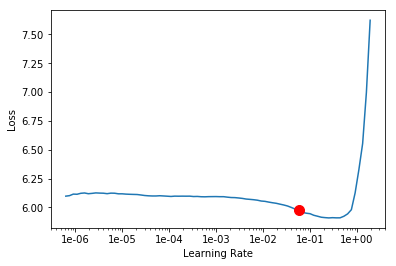

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(4, 1e-2, moms=(0.9,0.8))

epoch,train_loss,valid_loss,nll_loss
1,5.953584,5.722624,5.722624
2,5.572154,5.327883,5.327883
3,5.308914,5.227875,5.227875
4,5.108492,5.205208,5.205208


### Let's try to visualize some words 

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
model = model.cpu()

In [48]:
def get_2_dims(vocab_sz):
    emb = torch.tensor(np.array([i for i in range(vocab_sz)]).reshape(vocab_sz, 1))
    emb = to_np(model.e(emb)).squeeze()
    emb_pca = pca.fit(emb.T).components_
    return emb_pca[0], emb_pca[1] 

In [49]:
# get the embeddings for english words
en_dim1, en_dim2 = get_2_dims(e_vs) 

In [53]:
def plot_emb(dim1, dim2, i2w):
    X = dim1[20:40];Y = dim2[20:40]
    plt.figure(figsize=(15,15))
    plt.scatter(X, Y)
    for i, (x, y) in enumerate(zip(X, Y)):
        plt.text(x,y,u''.join([i2w[i]]), color=np.random.rand(3)*0.7, fontsize=11)
    plt.show()

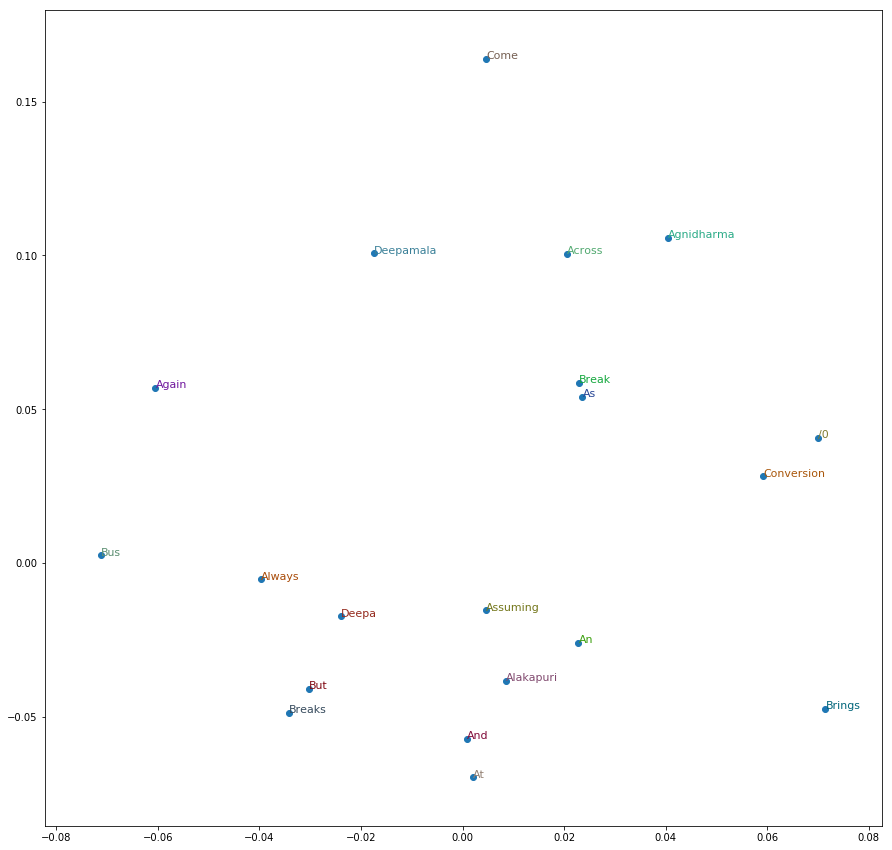

In [54]:
plot_emb(en_dim1, en_dim2, ei2w)

### Let's try clustering the words to discover some topics

In [85]:
from sklearn.cluster import KMeans

In [86]:
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx;

In [87]:
emb = torch.tensor(np.array([i for i in range(e_vs)]).reshape(e_vs, 1))
emb = to_np(model.e(emb)).squeeze()

In [88]:
centers, clusters = clustering_on_wordvecs(emb, 10);
centroid_map = dict(zip(ei2w, clusters));

In [89]:
from sklearn.neighbors import KDTree

In [90]:
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i)] = [index2word[j] for j in closest_words_idxs[i][0]]
    df = pd.DataFrame(closest_words);
    df.index = df.index+1
    return df;

In [91]:
top_words = get_top_words(ei2w, 10, centers, emb);

In [92]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from itertools import cycle
stopwords = set(STOPWORDS)

In [97]:
top_words

,Cluster #0,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9
1,Yun,then,such,pavani,next,Just,flesh,defeat,mosque,sun
2,rain,Work,ignore,flesh,flesh,sun,Non-linear,flesh,flesh,Jyotsna
3,first,flesh,started?,team,fill,lifespan,sun,sun,beginning,flesh
4,voice,team,lamp,First,off,lamp,sleep,school,many,school
5,dance,school,This,voice,sun,forest,Work,Work,Alakapuri,final
6,flesh,find,flesh,lamp,Work,flesh,frozen,find,Work,Work
7,Work,order,Work,flowers,form,get,beginning,have,well-known,heaven's
8,way,lamp,school,yearning,Deepa,Work,school,phase,burden,Lapful
9,Then,Lapful,long,jail,heaven's,Nadiya,will,lamp,lamp,order
10,sun,If,Where,dark,forest,find,So,voice,sun,off


In [103]:
def display_cloud(cluster_num, cmap):
    wc = WordCloud(background_color="black", max_words=8, max_font_size=80, colormap=cmap, stopwords=stopwords);
    wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_num)]]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('cluster_' + str(cluster_num), bbox_inches='tight')
    plt.show();

### Topics visualization

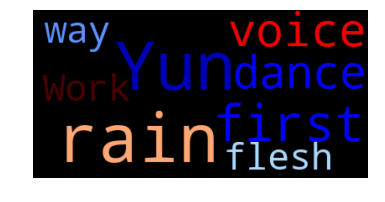

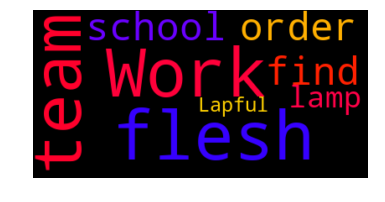

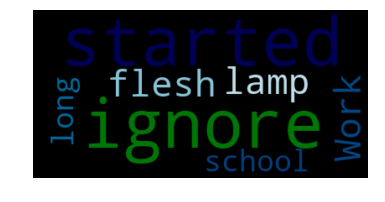

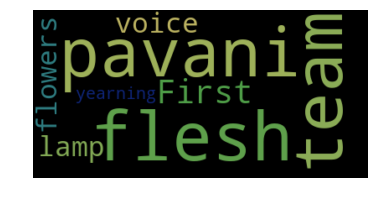

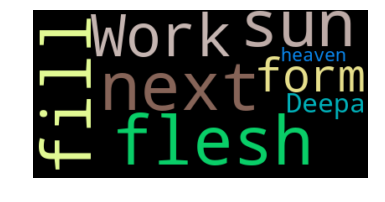

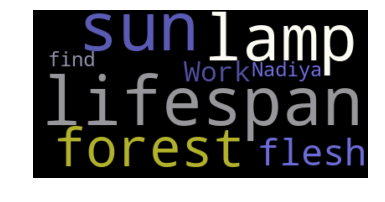

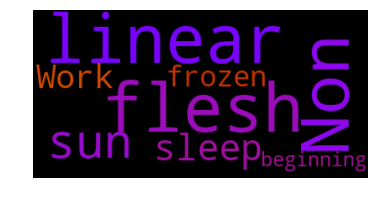

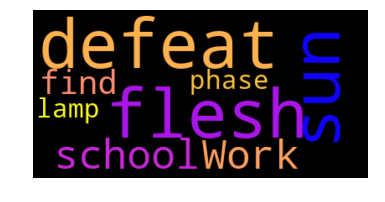

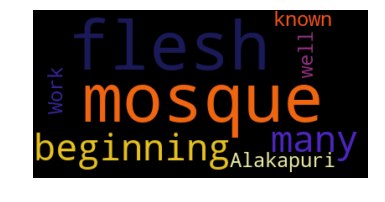

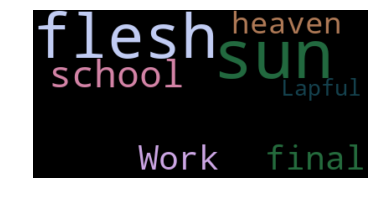

In [104]:
cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])
for i in range(10):
    col = next(cmaps);
    display_cloud(i, col)